In [2]:
import numpy	as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

In [3]:
datos = pd.read_csv('data.csv')
magnitud = datos.iloc[:, 0]
funcionlum = datos.iloc[:, 1]

In [4]:
def	schechter(x,M,phi,alpha):
				m = 0.4*np.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*np.exp(-10**(-0.4*(x-M)))
				return m

Derivo con python para evitar errores humanos

In [58]:
x, M, phi, alpha = sp.symbols('x M phi alpha')
m_sympy = 0.4*sp.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*sp.exp(-10**(-0.4*(x-M)))
derivadaM = sp.diff(m_sympy, M)
derivadaphi = sp.diff(m_sympy, phi)
derivadaalpha = sp.diff(m_sympy, alpha)
print(derivadaM)
print(derivadaphi)
print(derivadaalpha)

-0.16*10**((0.4*M - 0.4*x)*(alpha + 1))*10**(0.4*M - 0.4*x)*phi*exp(-10**(0.4*M - 0.4*x))*log(10)**2 + 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*alpha + 0.4)*exp(-10**(0.4*M - 0.4*x))*log(10)**2
0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*exp(-10**(0.4*M - 0.4*x))*log(10)
0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*M - 0.4*x)*exp(-10**(0.4*M - 0.4*x))*log(10)**2


Definimos las funciones

In [28]:
def diffM(x,	M, phi, alpha):
				return -0.16*10**((0.4*M - 0.4*x)*(alpha + 1))*10**(0.4*M - 0.4*x)*phi*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2 + 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*alpha + 0.4)*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2


def diffphi(x,	M, phi, alpha):
				return 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)

def diffalpha(x,	M, phi, alpha):
				return 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*M - 0.4*x)*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2

def gradiente(x, M, phi, alpha, sigma):
				grad = np.zeros(3)
				grad[0] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffM(magnitud, M, phi, alpha)/(sigma**2))
				grad[1] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffphi(magnitud, M, phi, alpha)/(sigma**2))
				grad[2] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffalpha(magnitud, M, phi, alpha)/(sigma**2))
				return grad

Las cotas

In [14]:
alphamin = -1.5
alphamax = -1.3
Mmin = -21
Mmax = -20.6
phimin = 1.2*(10**(-2))
phimax = 1.6*(10 ** (-2))

Las normalizaciones

In [15]:
def normM(M):
    return (M - Mmin) / ( Mmax - Mmin)

def anti_normM(M):
				return (M * (Mmax - Mmin)) + Mmin

def normphi(phi):
				return (phi - phimin) / (phimax - phimin)

def anti_normphi(phi):
				return (phi * (phimax - phimin)) + phimin

def normalpha(alpha):
				return (alpha - alphamin) / (alphamax - alphamin)

def anti_normalpha(alpha):
				return (alpha * (alphamax - alphamin)) + alphamin

Ahora si, el descenso por el gradiente

In [62]:
def graddes(x, y, sigma, N):
	#Lanzamos en un lugar al azar dentro de los priors.
	M = np.random.uniform(Mmin, Mmax)
	phi = np.random.uniform(phimin, phimax)
	alpha = np.random.uniform(alphamin, alphamax)
	#Armamos las listas donde guardaremos todo
	Mreccorridos	= np.zeros(N+1)
	phirecorridos = np.zeros(N+1)
	alpharecorridos = np.zeros(N+1)
	#Guardamos los primeros valores
	Mreccorridos[0] = M
	phirecorridos[0] = phi
	alpharecorridos[0] = alpha
	#Empezamos a recorrer
	for i in range(N):
		pp = 1e-5
		grad =	gradiente(x, M, phi, alpha, sigma)
		M_paso = normM(M) - normM(grad[0])*pp
		phi_paso = normphi(phi) - normphi(grad[1])*pp
		alpha_paso = normalpha(alpha) - normalpha(grad[2])*pp
		
		#Ahora, desonormalizamos para calcular la probabilidad:
		M_paso = anti_normM(M_paso)
		phi_paso = anti_normphi(phi_paso)
		alpha_paso = anti_normalpha(alpha_paso)
	# Evito que diverja
		M_paso = np.clip(M_paso, Mmin, Mmax)
		phi_paso = np.clip(phi_paso, phimin, phimax)
		alpha_paso = np.clip(alpha_paso, alphamin, alphamax)
	#Me los guardo en la lista
		Mreccorridos[i+1] = M_paso
		phirecorridos[i+1] = phi_paso
		alpharecorridos[i+1] = alpha_paso
		#Avanzo
		M = M_paso
		phi = phi_paso
		alpha = alpha_paso
	#Obtengo todos los valores de los parametros
	return	Mreccorridos, phirecorridos, alpharecorridos

In [63]:
erromin = datos.iloc[:,2]
erromax = datos.iloc[:,3]

sigma = (erromax-erromin) / 2

# Ejecutar el descenso por gradiente
mrec, phirec, alpharec = graddes(magnitud, funcionlum, sigma, 10000)

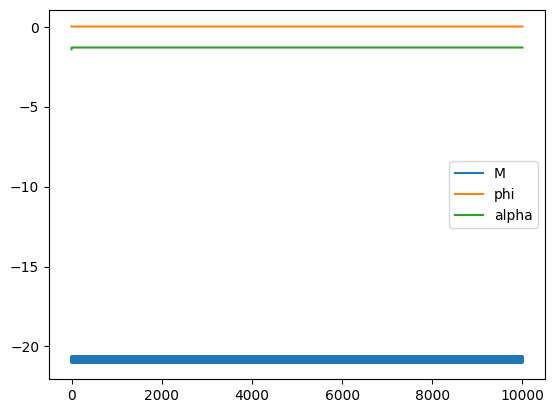

recorrido: [-20.95328835 -20.6        -21.         ... -21.         -20.6
 -21.        ] [0.01560834 0.012      0.012      ... 0.012      0.012      0.012     ] [-1.41051943 -1.3        -1.3        ... -1.3        -1.3
 -1.3       ]
Valores finales: -21.0 0.012 -1.3


In [64]:
# Graficar los resultados
plt.plot(mrec, label='M')
plt.plot(phirec, label='phi')
plt.plot(alpharec, label='alpha')
plt.legend()
plt.show()

print('recorrido:', mrec, phirec, alpharec)
print('Valores finales:',	mrec[-1], phirec[-1], alpharec[-1])